In [ ]:
# CNN Expts

In [1]:
# ======================================================
# 1️⃣ Imports
# ======================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset


# ======================================================
# 2️⃣ Lag Feature Function
# ======================================================

def create_lagged_features(df, target, lag=5, exclude_target=True):

    feature_cols = df.columns.drop(target) if exclude_target else df.columns

    df_lagged = pd.concat(
        [df[feature_cols].shift(i).add_suffix(f"_lag{i}")
         for i in range(lag, 0, -1)],
        axis=1
    )

    # Target is always current timestep
    df_lagged[target] = df[target]

    df_lagged = df_lagged.dropna()

    X = df_lagged.drop(columns=[target]).values
    y = df_lagged[target].values

    return X, y


def get_experiment_columns(experiment, video_cols, audio_cols, target, exclude_target=True):
    """
    experiment: 'video', 'audio', 'both'
    include_target: whether to explicitly add target column
    """

    if experiment == "video":
        used_cols = video_cols.copy()
    elif experiment == "audio":
        used_cols = audio_cols.copy()
    elif experiment == "both":
        used_cols = video_cols + audio_cols
    else:
        raise ValueError("Experiment must be 'video', 'audio', or 'both'")

    if exclude_target is False:
        used_cols = list(dict.fromkeys(used_cols + [target]))

    return used_cols


# ======================================================
# 6️⃣ CNN Architecture (2D CNN)
# ======================================================

class CNNLayer(nn.Module):
    def __init__(self, num_features, sequence_length, num_output):
        super(CNNLayer, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1))
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv2d(256, num_output, kernel_size=(1,1))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch,1,seq_len,num_features)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.global_avg_pool(x)

        return x.view(x.size(0), -1)


# ======================================================
# 7️⃣ Custom Weighted Loss
# ======================================================

def custom_loss(outputs, targets, w=10):
    base_loss = F.smooth_l1_loss(outputs, targets, reduction='none')
    weights = torch.ones_like(targets)
    weights[targets != 0] = w
    return (base_loss * weights).mean()


# ======================================================
# 8️⃣ Metrics
# ======================================================

def compute_metrics(predictions, targets):
    predictions = predictions.cpu().numpy()
    targets = targets.cpu().numpy()

    mae = mean_absolute_error(targets, predictions)
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    return mae, rmse, r2


# ======================================================
# 9️⃣ Training Loop
# ======================================================

def train_model(model, train_loader, epochs=20, device="cpu"):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    history = []

    for epoch in range(epochs):

        model.train()
        total_loss = 0
        all_preds, all_targets = [], []

        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = custom_loss(outputs, targets)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds.append(outputs.detach())
            all_targets.append(targets.detach())

        preds = torch.cat(all_preds)
        targs = torch.cat(all_targets)
        mae, rmse, r2 = compute_metrics(preds, targs)

        avg_loss = total_loss / len(train_loader)
        history.append(avg_loss)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {avg_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    return history


# ======================================================
# 🔟 Evaluation
# ======================================================

def evaluate(model, loader, device="cpu"):

    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for features, targets in loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            all_preds.append(outputs)
            all_targets.append(targets)

    preds = torch.cat(all_preds)
    targs = torch.cat(all_targets)

    mae, rmse, r2 = compute_metrics(preds, targs)

    print(f"\nTest -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    return preds.cpu().numpy(), targs.cpu().numpy()





In [3]:
def run_cnn_experiment(
    experiment,
    target,
    df_all,
    video_cols,
    audio_cols,
    lag=5,
    exclude_target=True,
    epochs=20,
    device="cpu",
    plot_training=False,
    plot_predictions=False
):

    print(f"\n==============================")
    print(f"Experiment: {experiment} | Target: {target}")
    print(f"==============================")

    # Select columns
    used_cols = get_experiment_columns(
        experiment,
        video_cols,
        audio_cols,
        target,
        exclude_target=False
    )

    df = df_all[used_cols].rolling(window=5, min_periods=1).mean()

    X, y = create_lagged_features(
        df,
        target,
        lag=lag,
        exclude_target=exclude_target
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    sequence_length = lag
    num_features = X_train.shape[1] // sequence_length

    X_train = X_train.reshape(-1, sequence_length, num_features)
    X_test  = X_test.reshape(-1, sequence_length, num_features)

    y_train = y_train.reshape(-1,1)
    y_test  = y_test.reshape(-1,1)

    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    )

    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32)
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = CNNLayer(
        num_features=num_features,
        sequence_length=sequence_length,
        num_output=1
    ).to(device)

    # -------------------------
    # Train
    # -------------------------

    history = train_model(model, train_loader, epochs=epochs, device=device)

    # Plot training loss
    if plot_training:
        plt.figure(figsize=(6,4))
        plt.plot(history)
        plt.title(f"{experiment.upper()} | {target} Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # -------------------------
    # Evaluate
    # -------------------------

    train_preds, train_targets = evaluate(model, train_loader, device=device)
    test_preds, test_targets = evaluate(model, test_loader, device=device)

    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = np.sqrt(mean_squared_error(train_targets, train_preds))
    train_r2 = r2_score(train_targets, train_preds)

    test_mae = mean_absolute_error(test_targets, test_preds)
    test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
    test_r2 = r2_score(test_targets, test_preds)

    # Plot predictions
    if plot_predictions:
        plt.figure(figsize=(10,5))
        plt.plot(test_targets, label="Actual")
        plt.plot(test_preds, label="Predicted")
        plt.title(f"{experiment.upper()} | {target} Test Prediction")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "Experiment": experiment,
        "Target": target,
        "Train_MAE": train_mae,
        "Train_RMSE": train_rmse,
        "Train_R2": train_r2,
        "Test_MAE": test_mae,
        "Test_RMSE": test_rmse,
        "Test_R2": test_r2
    }


Using device: cuda

Experiment: video | Target: B_to_P1
Epoch [1/20] Loss: 0.9318 | MAE: 0.3378 | RMSE: 0.5538 | R²: 0.6160
Epoch [2/20] Loss: 0.8997 | MAE: 0.3316 | RMSE: 0.5399 | R²: 0.6350
Epoch [3/20] Loss: 0.8552 | MAE: 0.3284 | RMSE: 0.5252 | R²: 0.6546
Epoch [4/20] Loss: 0.8297 | MAE: 0.3232 | RMSE: 0.5147 | R²: 0.6682
Epoch [5/20] Loss: 0.8436 | MAE: 0.3234 | RMSE: 0.5205 | R²: 0.6607
Epoch [6/20] Loss: 0.8297 | MAE: 0.3221 | RMSE: 0.5155 | R²: 0.6673
Epoch [7/20] Loss: 0.8181 | MAE: 0.3176 | RMSE: 0.5093 | R²: 0.6752
Epoch [8/20] Loss: 0.8297 | MAE: 0.3167 | RMSE: 0.5097 | R²: 0.6747
Epoch [9/20] Loss: 0.8178 | MAE: 0.3180 | RMSE: 0.5101 | R²: 0.6742
Epoch [10/20] Loss: 0.8153 | MAE: 0.3165 | RMSE: 0.5077 | R²: 0.6772
Epoch [11/20] Loss: 0.8101 | MAE: 0.3130 | RMSE: 0.5049 | R²: 0.6808
Epoch [12/20] Loss: 0.8067 | MAE: 0.3143 | RMSE: 0.5038 | R²: 0.6821
Epoch [13/20] Loss: 0.8133 | MAE: 0.3151 | RMSE: 0.5087 | R²: 0.6760
Epoch [14/20] Loss: 0.8021 | MAE: 0.3130 | RMSE: 0.5024 

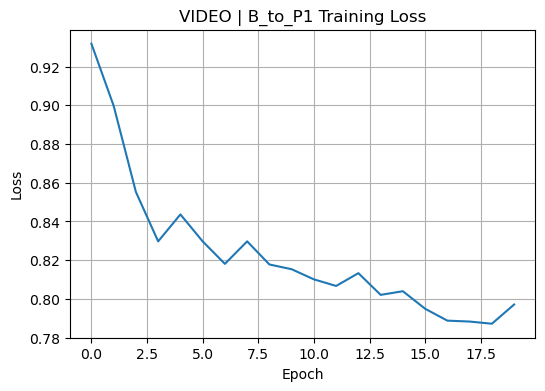


Test -> MAE: 0.2936 | RMSE: 0.4900 | R²: 0.6993

Test -> MAE: 0.2883 | RMSE: 0.5333 | R²: 0.4176


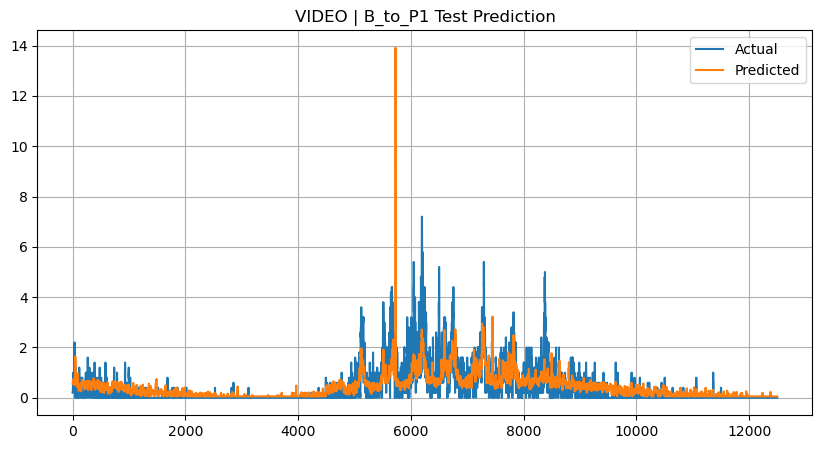


Experiment: video | Target: P1_to_B
Epoch [1/20] Loss: 1.0291 | MAE: 0.3605 | RMSE: 0.5571 | R²: 0.6169
Epoch [2/20] Loss: 0.9758 | MAE: 0.3578 | RMSE: 0.5442 | R²: 0.6344
Epoch [3/20] Loss: 0.9596 | MAE: 0.3545 | RMSE: 0.5385 | R²: 0.6420
Epoch [4/20] Loss: 0.9508 | MAE: 0.3526 | RMSE: 0.5332 | R²: 0.6490
Epoch [5/20] Loss: 0.9532 | MAE: 0.3537 | RMSE: 0.5364 | R²: 0.6448
Epoch [6/20] Loss: 0.9315 | MAE: 0.3493 | RMSE: 0.5275 | R²: 0.6565
Epoch [7/20] Loss: 0.9278 | MAE: 0.3480 | RMSE: 0.5271 | R²: 0.6570
Epoch [8/20] Loss: 0.9321 | MAE: 0.3490 | RMSE: 0.5290 | R²: 0.6545
Epoch [9/20] Loss: 0.9256 | MAE: 0.3480 | RMSE: 0.5252 | R²: 0.6595
Epoch [10/20] Loss: 0.9386 | MAE: 0.3476 | RMSE: 0.5244 | R²: 0.6605
Epoch [11/20] Loss: 0.9179 | MAE: 0.3480 | RMSE: 0.5220 | R²: 0.6636
Epoch [12/20] Loss: 0.9187 | MAE: 0.3454 | RMSE: 0.5238 | R²: 0.6613
Epoch [13/20] Loss: 0.9179 | MAE: 0.3459 | RMSE: 0.5219 | R²: 0.6638
Epoch [14/20] Loss: 0.9157 | MAE: 0.3466 | RMSE: 0.5216 | R²: 0.6642
Epoch 

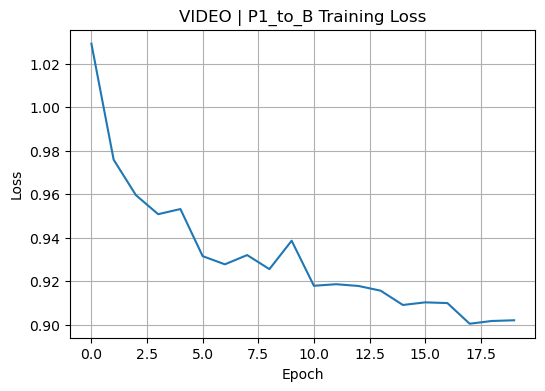


Test -> MAE: 0.3644 | RMSE: 0.5052 | R²: 0.6849

Test -> MAE: 0.3508 | RMSE: 0.5162 | R²: 0.5371


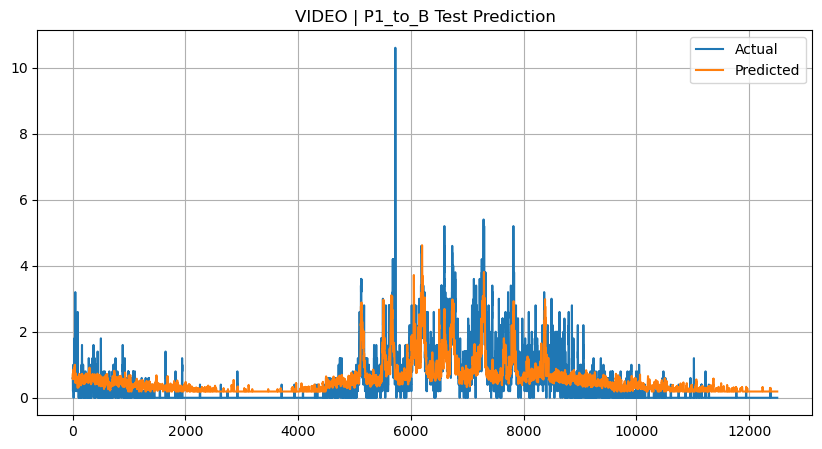


Experiment: video | Target: C_to_B
Epoch [1/20] Loss: 1.9664 | MAE: 0.5186 | RMSE: 0.8149 | R²: 0.5456
Epoch [2/20] Loss: 1.8858 | MAE: 0.5129 | RMSE: 0.8003 | R²: 0.5618
Epoch [3/20] Loss: 1.8817 | MAE: 0.5118 | RMSE: 0.7976 | R²: 0.5647
Epoch [4/20] Loss: 1.8615 | MAE: 0.5081 | RMSE: 0.7924 | R²: 0.5703
Epoch [5/20] Loss: 1.8575 | MAE: 0.5057 | RMSE: 0.7910 | R²: 0.5719
Epoch [6/20] Loss: 1.8485 | MAE: 0.5066 | RMSE: 0.7894 | R²: 0.5736
Epoch [7/20] Loss: 1.8365 | MAE: 0.5036 | RMSE: 0.7871 | R²: 0.5761
Epoch [8/20] Loss: 1.8436 | MAE: 0.5054 | RMSE: 0.7887 | R²: 0.5744
Epoch [9/20] Loss: 1.8414 | MAE: 0.5036 | RMSE: 0.7878 | R²: 0.5753
Epoch [10/20] Loss: 1.8156 | MAE: 0.5005 | RMSE: 0.7821 | R²: 0.5815
Epoch [11/20] Loss: 1.8411 | MAE: 0.5036 | RMSE: 0.7853 | R²: 0.5781
Epoch [12/20] Loss: 1.8307 | MAE: 0.5035 | RMSE: 0.7847 | R²: 0.5787
Epoch [13/20] Loss: 1.8217 | MAE: 0.5009 | RMSE: 0.7837 | R²: 0.5798
Epoch [14/20] Loss: 1.8274 | MAE: 0.5012 | RMSE: 0.7840 | R²: 0.5794
Epoch [

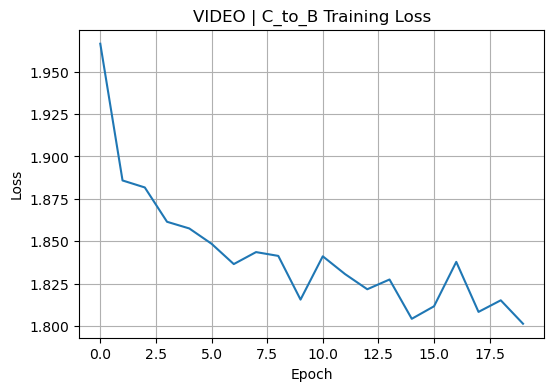


Test -> MAE: 0.4501 | RMSE: 0.7498 | R²: 0.6154

Test -> MAE: 0.4168 | RMSE: 0.6283 | R²: 0.6440


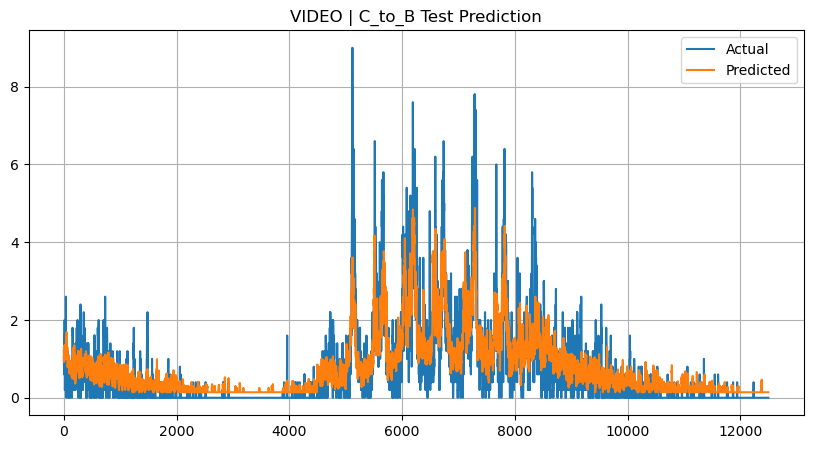


Experiment: video | Target: B_to_C
Epoch [1/20] Loss: 2.1265 | MAE: 0.5401 | RMSE: 0.8355 | R²: 0.5681
Epoch [2/20] Loss: 2.0517 | MAE: 0.5354 | RMSE: 0.8168 | R²: 0.5872
Epoch [3/20] Loss: 2.0314 | MAE: 0.5325 | RMSE: 0.8131 | R²: 0.5909
Epoch [4/20] Loss: 2.0176 | MAE: 0.5314 | RMSE: 0.8083 | R²: 0.5958
Epoch [5/20] Loss: 1.9997 | MAE: 0.5278 | RMSE: 0.8032 | R²: 0.6008
Epoch [6/20] Loss: 1.9944 | MAE: 0.5277 | RMSE: 0.8023 | R²: 0.6018
Epoch [7/20] Loss: 2.0021 | MAE: 0.5292 | RMSE: 0.8042 | R²: 0.5999
Epoch [8/20] Loss: 2.0011 | MAE: 0.5276 | RMSE: 0.8028 | R²: 0.6013
Epoch [9/20] Loss: 1.9957 | MAE: 0.5282 | RMSE: 0.8034 | R²: 0.6006
Epoch [10/20] Loss: 1.9795 | MAE: 0.5248 | RMSE: 0.7991 | R²: 0.6048
Epoch [11/20] Loss: 1.9798 | MAE: 0.5246 | RMSE: 0.7980 | R²: 0.6060
Epoch [12/20] Loss: 1.9817 | MAE: 0.5255 | RMSE: 0.7997 | R²: 0.6043
Epoch [13/20] Loss: 1.9640 | MAE: 0.5244 | RMSE: 0.7953 | R²: 0.6086
Epoch [14/20] Loss: 1.9615 | MAE: 0.5235 | RMSE: 0.7931 | R²: 0.6108
Epoch [

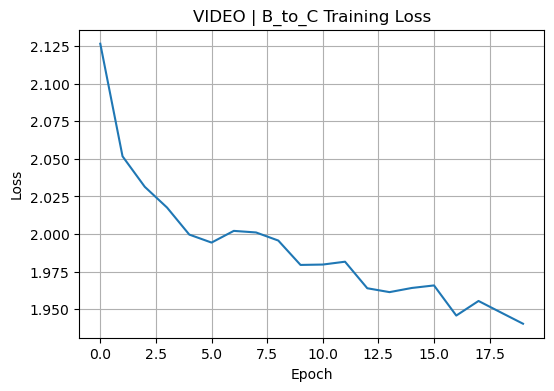


Test -> MAE: 0.5024 | RMSE: 0.7570 | R²: 0.6454

Test -> MAE: 0.4776 | RMSE: 0.6922 | R²: 0.5336


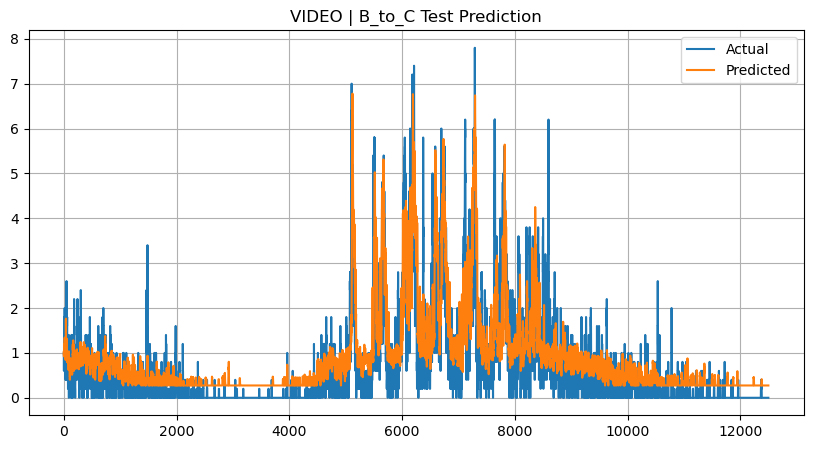


Experiment: audio | Target: B_to_P1
Epoch [1/20] Loss: 0.9375 | MAE: 0.3149 | RMSE: 0.5812 | R²: 0.5769
Epoch [2/20] Loss: 0.7691 | MAE: 0.2692 | RMSE: 0.4767 | R²: 0.7155
Epoch [3/20] Loss: 0.7095 | MAE: 0.2606 | RMSE: 0.4517 | R²: 0.7445
Epoch [4/20] Loss: 0.6759 | MAE: 0.2572 | RMSE: 0.4364 | R²: 0.7615
Epoch [5/20] Loss: 0.6543 | MAE: 0.2536 | RMSE: 0.4291 | R²: 0.7694
Epoch [6/20] Loss: 0.6524 | MAE: 0.2519 | RMSE: 0.4271 | R²: 0.7715
Epoch [7/20] Loss: 0.6424 | MAE: 0.2499 | RMSE: 0.4279 | R²: 0.7707
Epoch [8/20] Loss: 0.6194 | MAE: 0.2455 | RMSE: 0.4164 | R²: 0.7828
Epoch [9/20] Loss: 0.6304 | MAE: 0.2465 | RMSE: 0.4216 | R²: 0.7774
Epoch [10/20] Loss: 0.6214 | MAE: 0.2451 | RMSE: 0.4185 | R²: 0.7807
Epoch [11/20] Loss: 0.6109 | MAE: 0.2421 | RMSE: 0.4141 | R²: 0.7853
Epoch [12/20] Loss: 0.6014 | MAE: 0.2408 | RMSE: 0.4091 | R²: 0.7905
Epoch [13/20] Loss: 0.6123 | MAE: 0.2392 | RMSE: 0.4121 | R²: 0.7874
Epoch [14/20] Loss: 0.6036 | MAE: 0.2412 | RMSE: 0.4128 | R²: 0.7866
Epoch 

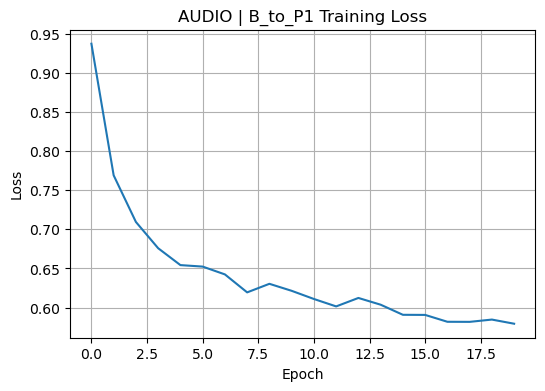


Test -> MAE: 0.2142 | RMSE: 0.3731 | R²: 0.8257

Test -> MAE: 0.1995 | RMSE: 0.3278 | R²: 0.7800


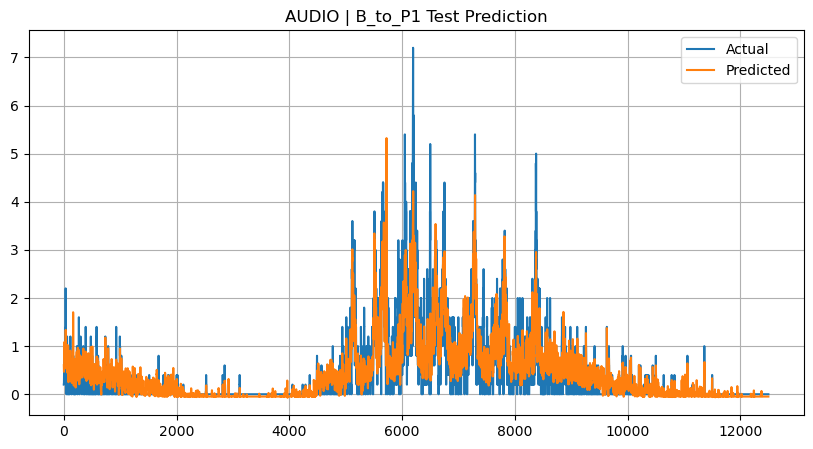


Experiment: audio | Target: P1_to_B
Epoch [1/20] Loss: 0.8456 | MAE: 0.2981 | RMSE: 0.5004 | R²: 0.6909
Epoch [2/20] Loss: 0.6942 | MAE: 0.2666 | RMSE: 0.4343 | R²: 0.7672
Epoch [3/20] Loss: 0.6623 | MAE: 0.2581 | RMSE: 0.4239 | R²: 0.7781
Epoch [4/20] Loss: 0.6451 | MAE: 0.2544 | RMSE: 0.4164 | R²: 0.7860
Epoch [5/20] Loss: 0.6386 | MAE: 0.2534 | RMSE: 0.4136 | R²: 0.7888
Epoch [6/20] Loss: 0.6290 | MAE: 0.2493 | RMSE: 0.4111 | R²: 0.7913
Epoch [7/20] Loss: 0.6230 | MAE: 0.2474 | RMSE: 0.4069 | R²: 0.7956
Epoch [8/20] Loss: 0.6029 | MAE: 0.2439 | RMSE: 0.3995 | R²: 0.8029
Epoch [9/20] Loss: 0.5913 | MAE: 0.2406 | RMSE: 0.3953 | R²: 0.8071
Epoch [10/20] Loss: 0.5792 | MAE: 0.2371 | RMSE: 0.3902 | R²: 0.8121
Epoch [11/20] Loss: 0.5832 | MAE: 0.2367 | RMSE: 0.3907 | R²: 0.8115
Epoch [12/20] Loss: 0.5927 | MAE: 0.2380 | RMSE: 0.3945 | R²: 0.8079
Epoch [13/20] Loss: 0.5767 | MAE: 0.2351 | RMSE: 0.3883 | R²: 0.8139
Epoch [14/20] Loss: 0.5723 | MAE: 0.2345 | RMSE: 0.3868 | R²: 0.8153
Epoch 

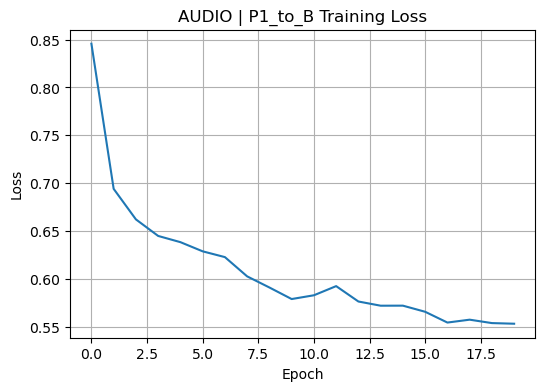


Test -> MAE: 0.2282 | RMSE: 0.3611 | R²: 0.8390

Test -> MAE: 0.2273 | RMSE: 0.3581 | R²: 0.7772


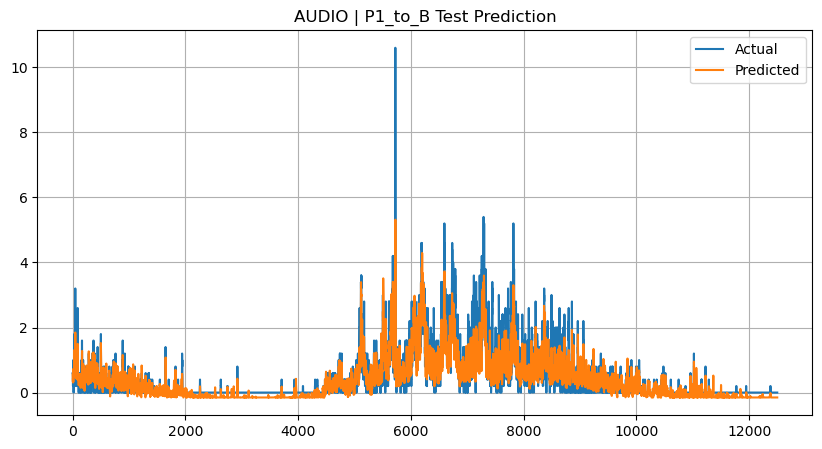


Experiment: audio | Target: C_to_B
Epoch [1/20] Loss: 1.6423 | MAE: 0.4326 | RMSE: 0.7140 | R²: 0.6511
Epoch [2/20] Loss: 1.4391 | MAE: 0.3900 | RMSE: 0.6582 | R²: 0.7036
Epoch [3/20] Loss: 1.4071 | MAE: 0.3862 | RMSE: 0.6502 | R²: 0.7108
Epoch [4/20] Loss: 1.3666 | MAE: 0.3786 | RMSE: 0.6413 | R²: 0.7186
Epoch [5/20] Loss: 1.3622 | MAE: 0.3744 | RMSE: 0.6358 | R²: 0.7234
Epoch [6/20] Loss: 1.3458 | MAE: 0.3715 | RMSE: 0.6313 | R²: 0.7273
Epoch [7/20] Loss: 1.3264 | MAE: 0.3668 | RMSE: 0.6263 | R²: 0.7316
Epoch [8/20] Loss: 1.3224 | MAE: 0.3662 | RMSE: 0.6216 | R²: 0.7357
Epoch [9/20] Loss: 1.3044 | MAE: 0.3628 | RMSE: 0.6197 | R²: 0.7372
Epoch [10/20] Loss: 1.2992 | MAE: 0.3621 | RMSE: 0.6163 | R²: 0.7401
Epoch [11/20] Loss: 1.3020 | MAE: 0.3626 | RMSE: 0.6164 | R²: 0.7400
Epoch [12/20] Loss: 1.2850 | MAE: 0.3593 | RMSE: 0.6118 | R²: 0.7439
Epoch [13/20] Loss: 1.2782 | MAE: 0.3567 | RMSE: 0.6082 | R²: 0.7469
Epoch [14/20] Loss: 1.2640 | MAE: 0.3548 | RMSE: 0.6065 | R²: 0.7483
Epoch [

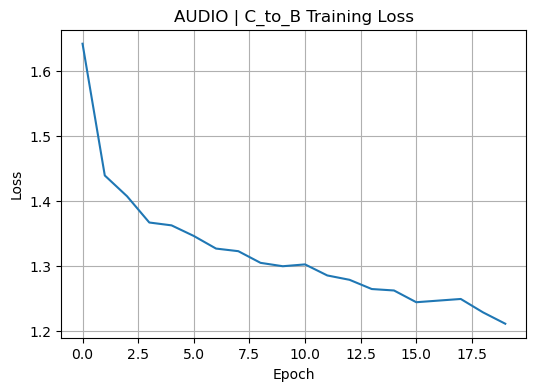


Test -> MAE: 0.3226 | RMSE: 0.5520 | R²: 0.7915

Test -> MAE: 0.2888 | RMSE: 0.4586 | R²: 0.8103


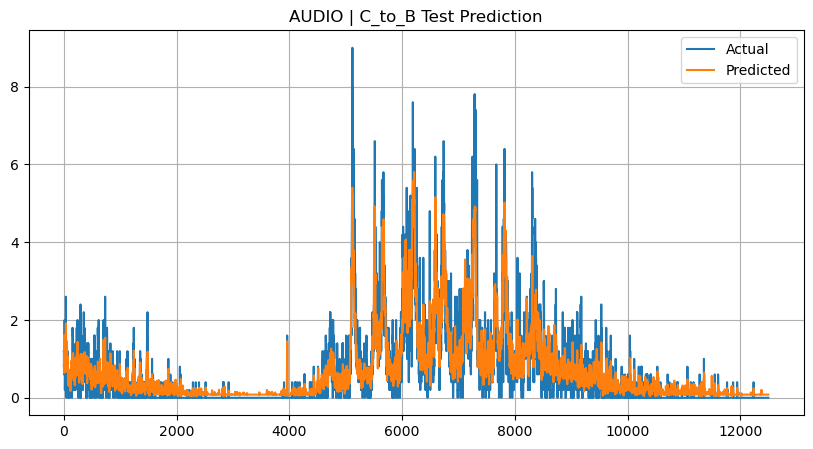


Experiment: audio | Target: B_to_C
Epoch [1/20] Loss: 1.9478 | MAE: 0.4826 | RMSE: 0.7895 | R²: 0.6143
Epoch [2/20] Loss: 1.6729 | MAE: 0.4257 | RMSE: 0.7149 | R²: 0.6838
Epoch [3/20] Loss: 1.6126 | MAE: 0.4167 | RMSE: 0.6974 | R²: 0.6991
Epoch [4/20] Loss: 1.5830 | MAE: 0.4070 | RMSE: 0.6915 | R²: 0.7041
Epoch [5/20] Loss: 1.5593 | MAE: 0.4008 | RMSE: 0.6834 | R²: 0.7110
Epoch [6/20] Loss: 1.5343 | MAE: 0.3954 | RMSE: 0.6756 | R²: 0.7175
Epoch [7/20] Loss: 1.5187 | MAE: 0.3930 | RMSE: 0.6696 | R²: 0.7226
Epoch [8/20] Loss: 1.4984 | MAE: 0.3875 | RMSE: 0.6658 | R²: 0.7257
Epoch [9/20] Loss: 1.4852 | MAE: 0.3865 | RMSE: 0.6625 | R²: 0.7285
Epoch [10/20] Loss: 1.4734 | MAE: 0.3833 | RMSE: 0.6589 | R²: 0.7314
Epoch [11/20] Loss: 1.4479 | MAE: 0.3819 | RMSE: 0.6504 | R²: 0.7382
Epoch [12/20] Loss: 1.4598 | MAE: 0.3815 | RMSE: 0.6513 | R²: 0.7375
Epoch [13/20] Loss: 1.4315 | MAE: 0.3788 | RMSE: 0.6446 | R²: 0.7429
Epoch [14/20] Loss: 1.4447 | MAE: 0.3771 | RMSE: 0.6486 | R²: 0.7397
Epoch [

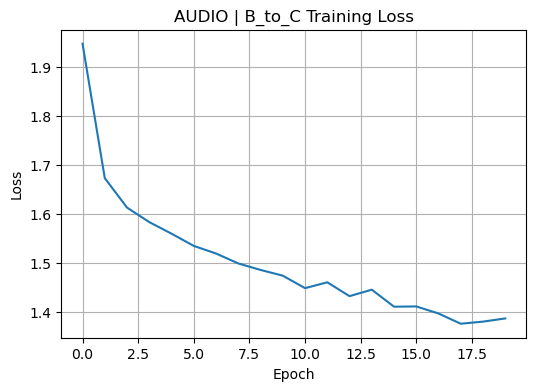


Test -> MAE: 0.3903 | RMSE: 0.5994 | R²: 0.7777

Test -> MAE: 0.3762 | RMSE: 0.5623 | R²: 0.6922


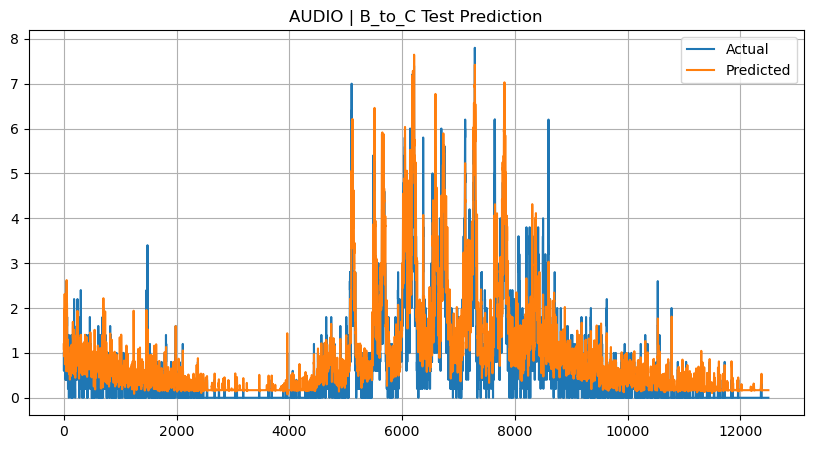


Experiment: both | Target: B_to_P1
Epoch [1/20] Loss: 0.8998 | MAE: 0.2940 | RMSE: 0.5620 | R²: 0.6045
Epoch [2/20] Loss: 0.7613 | MAE: 0.2696 | RMSE: 0.4751 | R²: 0.7173
Epoch [3/20] Loss: 0.7219 | MAE: 0.2679 | RMSE: 0.4581 | R²: 0.7372
Epoch [4/20] Loss: 0.6852 | MAE: 0.2654 | RMSE: 0.4436 | R²: 0.7535
Epoch [5/20] Loss: 0.6663 | MAE: 0.2599 | RMSE: 0.4378 | R²: 0.7600
Epoch [6/20] Loss: 0.6665 | MAE: 0.2594 | RMSE: 0.4373 | R²: 0.7606
Epoch [7/20] Loss: 0.6327 | MAE: 0.2521 | RMSE: 0.4230 | R²: 0.7759
Epoch [8/20] Loss: 0.6372 | MAE: 0.2510 | RMSE: 0.4213 | R²: 0.7777
Epoch [9/20] Loss: 0.6241 | MAE: 0.2501 | RMSE: 0.4164 | R²: 0.7829
Epoch [10/20] Loss: 0.6187 | MAE: 0.2472 | RMSE: 0.4169 | R²: 0.7824
Epoch [11/20] Loss: 0.6030 | MAE: 0.2450 | RMSE: 0.4096 | R²: 0.7899
Epoch [12/20] Loss: 0.6073 | MAE: 0.2434 | RMSE: 0.4125 | R²: 0.7870
Epoch [13/20] Loss: 0.6031 | MAE: 0.2440 | RMSE: 0.4129 | R²: 0.7865
Epoch [14/20] Loss: 0.5943 | MAE: 0.2400 | RMSE: 0.4063 | R²: 0.7933
Epoch [

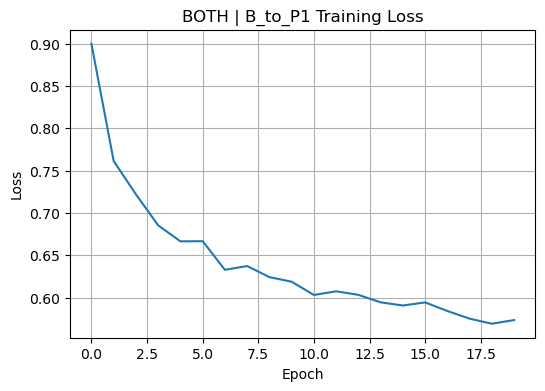


Test -> MAE: 0.2321 | RMSE: 0.3698 | R²: 0.8287

Test -> MAE: 0.2219 | RMSE: 0.3328 | R²: 0.7732


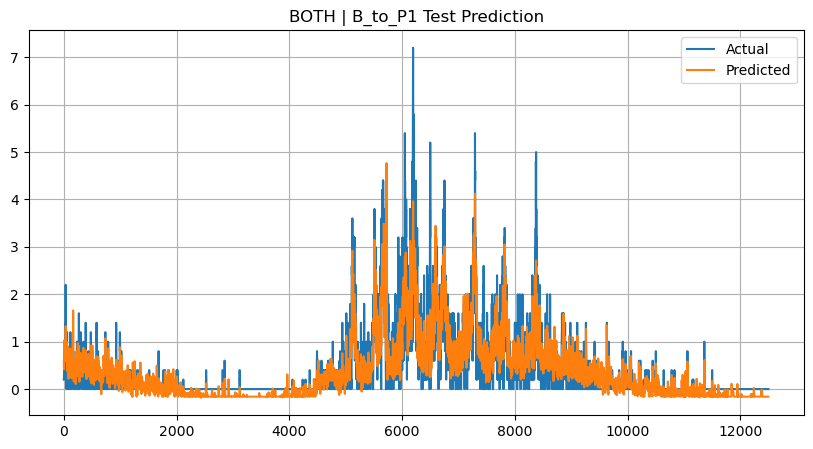


Experiment: both | Target: P1_to_B
Epoch [1/20] Loss: 0.9263 | MAE: 0.3177 | RMSE: 0.5324 | R²: 0.6500
Epoch [2/20] Loss: 0.7226 | MAE: 0.2675 | RMSE: 0.4420 | R²: 0.7588
Epoch [3/20] Loss: 0.6823 | MAE: 0.2599 | RMSE: 0.4298 | R²: 0.7720
Epoch [4/20] Loss: 0.6653 | MAE: 0.2573 | RMSE: 0.4233 | R²: 0.7788
Epoch [5/20] Loss: 0.6423 | MAE: 0.2517 | RMSE: 0.4152 | R²: 0.7872
Epoch [6/20] Loss: 0.6305 | MAE: 0.2479 | RMSE: 0.4111 | R²: 0.7914
Epoch [7/20] Loss: 0.6233 | MAE: 0.2482 | RMSE: 0.4082 | R²: 0.7943
Epoch [8/20] Loss: 0.6061 | MAE: 0.2418 | RMSE: 0.4008 | R²: 0.8017
Epoch [9/20] Loss: 0.6096 | MAE: 0.2433 | RMSE: 0.4018 | R²: 0.8007
Epoch [10/20] Loss: 0.6062 | MAE: 0.2415 | RMSE: 0.4010 | R²: 0.8015
Epoch [11/20] Loss: 0.5865 | MAE: 0.2379 | RMSE: 0.3939 | R²: 0.8084
Epoch [12/20] Loss: 0.5882 | MAE: 0.2378 | RMSE: 0.3944 | R²: 0.8080
Epoch [13/20] Loss: 0.5713 | MAE: 0.2349 | RMSE: 0.3869 | R²: 0.8152
Epoch [14/20] Loss: 0.5785 | MAE: 0.2355 | RMSE: 0.3922 | R²: 0.8101
Epoch [

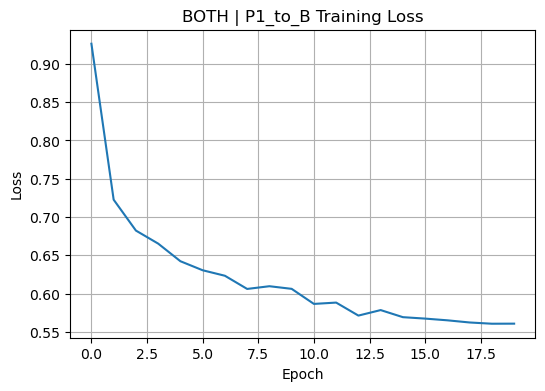


Test -> MAE: 0.2072 | RMSE: 0.3529 | R²: 0.8463

Test -> MAE: 0.1938 | RMSE: 0.3415 | R²: 0.7974


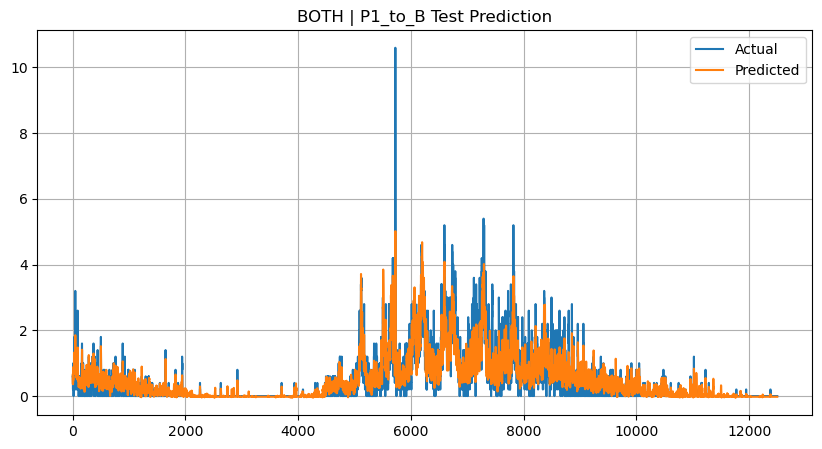


Experiment: both | Target: C_to_B
Epoch [1/20] Loss: 1.6776 | MAE: 0.4376 | RMSE: 0.7250 | R²: 0.6404
Epoch [2/20] Loss: 1.4674 | MAE: 0.3960 | RMSE: 0.6693 | R²: 0.6935
Epoch [3/20] Loss: 1.4174 | MAE: 0.3868 | RMSE: 0.6551 | R²: 0.7063
Epoch [4/20] Loss: 1.3977 | MAE: 0.3829 | RMSE: 0.6494 | R²: 0.7114
Epoch [5/20] Loss: 1.3835 | MAE: 0.3807 | RMSE: 0.6473 | R²: 0.7133
Epoch [6/20] Loss: 1.3665 | MAE: 0.3753 | RMSE: 0.6397 | R²: 0.7200
Epoch [7/20] Loss: 1.3385 | MAE: 0.3692 | RMSE: 0.6303 | R²: 0.7282
Epoch [8/20] Loss: 1.3157 | MAE: 0.3660 | RMSE: 0.6252 | R²: 0.7325
Epoch [9/20] Loss: 1.3137 | MAE: 0.3644 | RMSE: 0.6259 | R²: 0.7319
Epoch [10/20] Loss: 1.3071 | MAE: 0.3621 | RMSE: 0.6230 | R²: 0.7345
Epoch [11/20] Loss: 1.2914 | MAE: 0.3598 | RMSE: 0.6171 | R²: 0.7394
Epoch [12/20] Loss: 1.2686 | MAE: 0.3547 | RMSE: 0.6087 | R²: 0.7464
Epoch [13/20] Loss: 1.2762 | MAE: 0.3553 | RMSE: 0.6117 | R²: 0.7440
Epoch [14/20] Loss: 1.2868 | MAE: 0.3569 | RMSE: 0.6125 | R²: 0.7433
Epoch [1

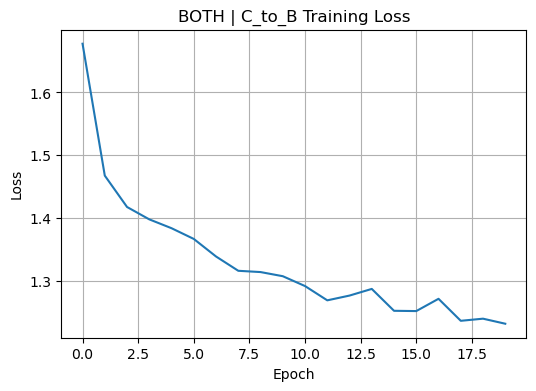


Test -> MAE: 0.3254 | RMSE: 0.5905 | R²: 0.7614

Test -> MAE: 0.2828 | RMSE: 0.4695 | R²: 0.8012


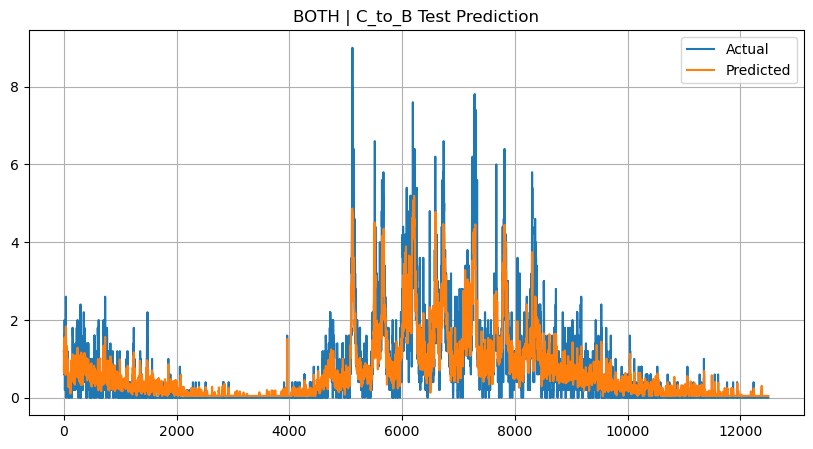


Experiment: both | Target: B_to_C
Epoch [1/20] Loss: 1.9468 | MAE: 0.4810 | RMSE: 0.7793 | R²: 0.6242
Epoch [2/20] Loss: 1.7116 | MAE: 0.4356 | RMSE: 0.7231 | R²: 0.6764
Epoch [3/20] Loss: 1.6623 | MAE: 0.4271 | RMSE: 0.7061 | R²: 0.6915
Epoch [4/20] Loss: 1.6153 | MAE: 0.4197 | RMSE: 0.6980 | R²: 0.6986
Epoch [5/20] Loss: 1.5767 | MAE: 0.4100 | RMSE: 0.6897 | R²: 0.7057
Epoch [6/20] Loss: 1.5677 | MAE: 0.4047 | RMSE: 0.6855 | R²: 0.7092
Epoch [7/20] Loss: 1.5476 | MAE: 0.4006 | RMSE: 0.6797 | R²: 0.7141
Epoch [8/20] Loss: 1.5272 | MAE: 0.3974 | RMSE: 0.6723 | R²: 0.7203
Epoch [9/20] Loss: 1.5096 | MAE: 0.3950 | RMSE: 0.6666 | R²: 0.7250
Epoch [10/20] Loss: 1.5003 | MAE: 0.3908 | RMSE: 0.6666 | R²: 0.7251
Epoch [11/20] Loss: 1.4979 | MAE: 0.3909 | RMSE: 0.6656 | R²: 0.7259
Epoch [12/20] Loss: 1.4748 | MAE: 0.3862 | RMSE: 0.6585 | R²: 0.7317
Epoch [13/20] Loss: 1.4518 | MAE: 0.3802 | RMSE: 0.6522 | R²: 0.7368
Epoch [14/20] Loss: 1.4584 | MAE: 0.3821 | RMSE: 0.6518 | R²: 0.7371
Epoch [1

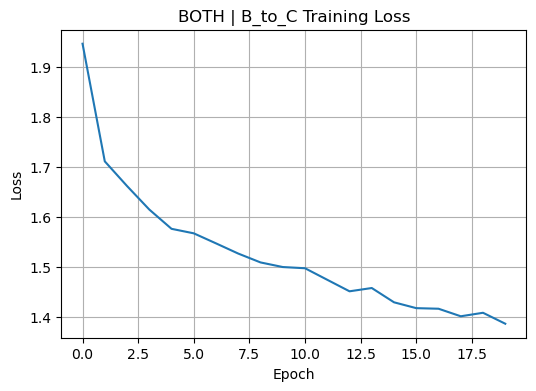


Test -> MAE: 0.3434 | RMSE: 0.5856 | R²: 0.7878

Test -> MAE: 0.3213 | RMSE: 0.5373 | R²: 0.7190


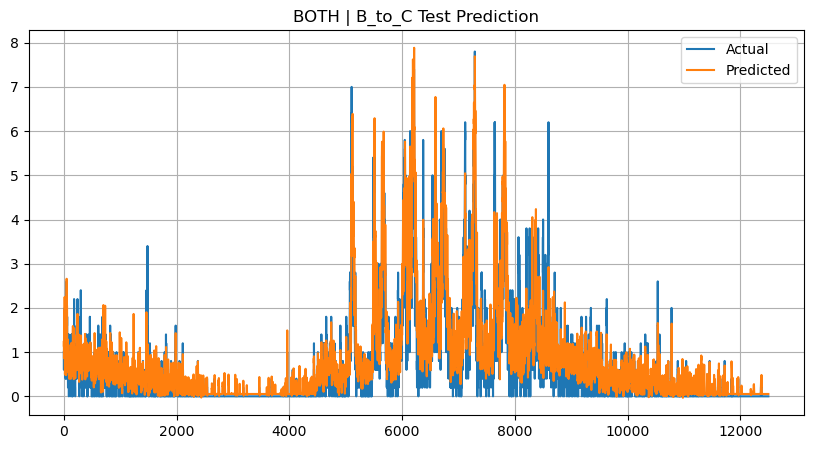


Final Results:
   Experiment   Target  Train_MAE  Train_RMSE  Train_R2  Test_MAE  Test_RMSE  \
0       audio   B_to_C   0.390321    0.599368  0.777717  0.376239   0.562303   
1        both   B_to_C   0.343423    0.585644  0.787780  0.321282   0.537299   
2       video   B_to_C   0.502402    0.756973  0.645448  0.477591   0.692225   
3       audio  B_to_P1   0.214228    0.373078  0.825701  0.199463   0.327787   
4        both  B_to_P1   0.232063    0.369809  0.828742  0.221909   0.332813   
5       video  B_to_P1   0.293600    0.489993  0.699341  0.288335   0.533316   
6       audio   C_to_B   0.322647    0.552039  0.791481  0.288839   0.458625   
7        both   C_to_B   0.325406    0.590480  0.761429  0.282836   0.469542   
8       video   C_to_B   0.450094    0.749760  0.615363  0.416774   0.628271   
9       audio  P1_to_B   0.228157    0.361085  0.839046  0.227328   0.358096   
10       both  P1_to_B   0.207165    0.352859  0.846296  0.193849   0.341479   
11      video  P1_to_B  

In [5]:
# ======================================================
# MAIN MULTI-EXPERIMENT LOOP
# ======================================================

df_all = pd.read_csv("../data/video_count_data_three_zones_10s_audio_video.csv")
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])
df_all = df_all.sort_values("timestamp").set_index("timestamp")

video_cols = ["B_to_P1", "P1_to_B", "C_to_B", "B_to_C"]

audio_cols = [
    'recorder1_9m_b','recorder2_9m_b','recorder3_9m_b',
    'recorder1_9m_p1','recorder2_9m_p1',
    'recorder1_9m_c','recorder2_9m_c'
]

experiments = ["video", "audio", "both"]
targets = video_cols

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

results = []

for experiment in experiments:
    for target in targets:

        result = run_cnn_experiment(
            experiment=experiment,
            target=target,
            df_all=df_all,
            video_cols=video_cols,
            audio_cols=audio_cols,
            lag=5,
            exclude_target=True,
            epochs=20,
            device=device,
            plot_training=True,
            plot_predictions=True
        )

        results.append(result)


# ======================================================
# STORE RESULTS
# ======================================================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["Target", "Experiment"]).reset_index(drop=True)

print("\nFinal Results:")
print(results_df)

results_df.to_csv("cnn_experiment_results.csv", index=False)
